In [1]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
from torchvision import models, transforms as T
import torchvision.transforms.functional as F
import numpy as np
import os
from patchify import patchify, unpatchify
import matplotlib.pyplot as plt
import nbimporter
from patches import read_and_patch_images
# from visualization import show, show_grid, mask_images

In [2]:
voc_dir = 'C:/Users/Hayden/Machine Learning/d2l/d2l-en/pytorch/chapter_computer-vision/data/VOCdevkit/VOC2012/'

In [3]:
# class VocDataset_old(Dataset):
#     '''Dataset that pre-loads the PASCAL2 VOC 2012 dataset into RAM. This implies that the DataLoader must have num_workers=0. The argument "transforms" must be a transformation ending with ToTensor.'''
#     def __init__(self, data_dir, transforms, dataset_type):
#         self.data_dir = data_dir
#         self.transforms = transforms
#         self.dataset_type = dataset_type
#         self.normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#         self.images, self.masks = self.load_images()

#     def load_images(self):
#         images, masks = read_and_patch_images(self.data_dir, self.dataset_type)
#         # images, masks = torch.from_numpy(images), torch.from_numpy(masks)
#         images = images.squeeze(1)
#         masks = masks.squeeze(1)

#         # my_stack = torch.empty(0)
#         # for image in images:
#         #     print('transforms')
#         #     new_image = self.transforms(image).to(torch.float32)
#         #     print('normalize')
#         #     norm_image = self.normalize(new_image)
#         #     print('stack')
#         #     my_stack = torch.stack((my_stack, norm_image))
#         images = torch.stack([
#             self.normalize(self.transforms(image).to(torch.float32))
#             for image in images
#         ])
#         masks = torch.stack([
#             self.transforms(mask).to(torch.float32)
#             for mask in masks
#         ])
#         print('TENSOR', images.shape, type(images), type(images[0]), type(images[0][0]), type(images[0][0][0]))
        
#         return images, masks

#     def __len__(self):
#         return len(self.images)

#     def __getitem__(self, index):
#         return self.images[index], self.masks[index]

# # transforms = torchvision.transforms.ToTensor()
# transforms = T.Compose([
#     # T.RandomHorizontalFlip(),
#     # T.RandomVerticalFlip(),
#     T.ToTensor()
# ])
# train_set = VocDataset_old(voc_dir, transforms, 'train')

In [4]:
# train_iter = torch.utils.data.DataLoader(train_set, 256, shuffle=True, drop_last=True, num_workers=0)
# # import nbimporter
# # import utils

# # DATA_DIR = 'C:/Users/Hayden/Machine Learning/d2l/d2l-en/pytorch/chapter_computer-vision/data/VOCdevkit/VOC2012/'
# # BATCH_SIZE=16
# # train_transform = T.Compose([
# #     T.RandomHorizontalFlip(),
# #     T.RandomVerticalFlip(),
# #     T.ToTensor()
# # ])
# # validation_transform = T.Compose([
# #     T.ToTensor()
# # ])
# # test_transform = T.Compose([
# #     T.ToTensor()
# # ])
# # train_loader, validation_loader, test_loader = utils.get_data_loaders(
# #     data_dir=DATA_DIR,
# #     train_transforms=train_transform,
# #     validation_transforms=validation_transform,
# #     test_transforms=test_transform,
# #     batch_size=BATCH_SIZE,
# # )
# # train_iter, val_iter, test_iter = utils.get_data_loaders(DATA_DIR, train_transform, validation_transform, test_transform, BATCH_SIZE)

# print('Total number of batches:', len(train_iter))
# for X, Y in train_iter:
#     print('X shape:', X.shape)
#     print('Y shape:', Y.shape)
#     print(type(X))
#     break

In [5]:
class VocDataset(Dataset):
    def __init__(self, data_dir, image_transform, mask_transform, crop_size, dataset):
        '''dataset must be a string of the following: "train", "trainval", "val" or "test".'''
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.crop_size = crop_size
        self.normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.data_paths = self.get_data_paths(data_dir, dataset)

    def get_data_paths(self, data_dir, dataset):
        '''Returns a list of tuples containing the path to both the images and their respective masks for all images greater than self.crop_size.'''
        annotations_file = os.path.join(data_dir, 'ImageSets', 'Segmentation', dataset+'.txt')

        with open(annotations_file, 'r') as f:
            file_names = f.read().split()
        
        paths = []
        for file_name in file_names:
            image_path = os.path.join(data_dir, 'JPEGImages', f'{file_name}.jpg')
            with Image.open(image_path) as img:
                width, height = img.size
            if width >= 256 and height >= 256:
                mask_path = os.path.join(data_dir, 'SegmentationClass', f'{file_name}.png')
                paths.append((image_path, mask_path))
        
        return paths
    
    def load_data(self, index, image_path, mask_path):
        image, mask = self.data_paths[index][0], self.data_paths[index][1]
        image, mask = Image.open(image_path), Image.open(mask_path)
        return image, mask

    def __len__(self):
        return len(self.data_paths)

    def __getitem__(self, index):
        image_path, mask_path = self.data_paths[index][0], self.data_paths[index][1]
        image, mask = self.load_data(index, image_path, mask_path)

        crop_params = T.RandomCrop(self.crop_size).get_params(image, self.crop_size)
        image = F.crop(image, *crop_params)
        mask = F.crop(mask, *crop_params)

        # totensor = T.ToTensor()
        # image = totensor(image)
        # mask = totensor(mask)
        image = self.normalize(self.image_transform(image)).to(torch.float32)
        mask = self.mask_transform(mask).to(torch.float32)

        return image, mask

In [6]:
# # ImageNet normalization values
# image_transform = T.Compose([
#     T.Resize((256, 256)),
#     T.ToTensor()
#     # T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# # For masks (don't normalize, keep as long tensors)
# mask_transform = T.Compose([
#     T.Resize((256, 256), interpolation=Image.NEAREST),
#     T.PILToTensor(),  # Output shape: [1, H, W]
#     # T.Lambda(lambda x: x.squeeze(0).long())  # convert to shape: [H, W]
#     T.Lambda(lambda x: torch.from_numpy(np.array(x)).long())
# ])

# from torch.utils.data import DataLoader

# # Assuming VOC2012 is in ./VOCdevkit/VOC2012
# dataset = VocDataset(
#     data_dir=voc_dir,
#     image_transform=image_transform,
#     mask_transform=mask_transform,
#     crop_size=(256, 256),
#     dataset='train'
# )

# dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [7]:
# import matplotlib.pyplot as plt
# import numpy as np

# def denormalize(img_tensor):
#     """Undo ImageNet normalization for visualization"""
#     mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
#     std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
#     img = img_tensor * std + mean
#     return img.clamp(0, 1)

# # View a batch
# for images, masks in dataloader:
    
#     print('DONE')

#     img = images[0].permute(1, 2, 0).numpy()
#     mask = masks[0].permute(1, 2, 0).numpy().astype('int64')

#     plt.figure(figsize=(10, 4))
#     plt.subplot(1, 4, 1)
#     plt.imshow(img)
#     plt.title("Image")
#     plt.axis('off')

#     image = denormalize(images[0]).permute(1, 2, 0).numpy()
#     plt.subplot(1, 4, 2)
#     plt.imshow(image)
#     plt.title("Denormalized Image")
#     plt.axis('off')
    
#     plt.subplot(1, 4, 3)
#     plt.imshow(mask)
#     plt.title("Segmentation Mask")
#     plt.axis('off')

#     masked_pixels = masks[0] != torch.zeros_like(masks[0])
#     masked_image = torchvision.utils.draw_segmentation_masks((torch.from_numpy(image)*255).clamp(0, 255).permute(2, 0, 1).to(torch.uint8), masked_pixels, alpha=0.5, colors=(255, 0, 0))
#     # masked_image = torchvision.utils.draw_segmentation_masks(images[0].to(torch.uint8), masked_pixels, 0.6, (0, 128, 128))
#     plt.subplot(1, 4, 4)
#     plt.imshow(masked_image.permute(1, 2, 0))
#     plt.title("Segmented Image")
#     plt.axis('off')

#     plt.show()
#     break


In [ ]:
def get_data_loader(data_dir, image_transform, mask_transform, crop_size, dataset):
    '''dataset must be one of the following: "train", "val" or "test"'''
    set = VocDataset(data_dir, image_transform, mask_transform, crop_size, dataset)
    loader = DataLoader(set, 32, shuffle=True, num_workers=0, drop_last=True)
    return loader

In [ ]:
crop_size = (256, 256)
# crop_size = (100, 100)
transform = T.ToTensor()
train_set = get_data_loader(transform, transform, crop_size, 'train')

In [9]:
for image, mask in train_set:
    print(image.shape)
    print(mask.shape)
    # visualization.show(image)
    # visualization.show(mask)
    break

torch.Size([32, 3, 256, 256])
torch.Size([32, 1, 256, 256])


In [10]:
for image, mask in train_set:
    print(image.shape)
    print(mask.shape)
    break

torch.Size([32, 3, 256, 256])
torch.Size([32, 1, 256, 256])


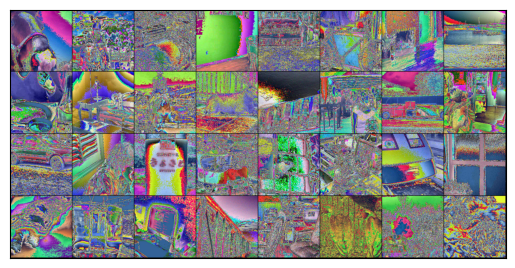

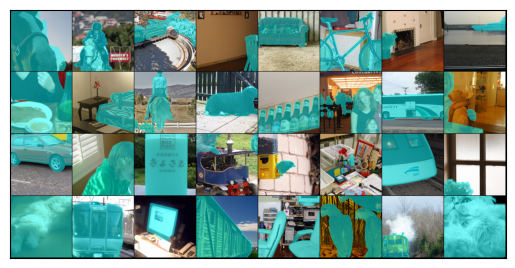

In [32]:
# from visualization import show, show_grid, mask_images
import visualization

def denormalize(img_tensor):
    """Undo ImageNet normalization for visualization"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img_tensor * std + mean
    return img.clamp(0, 1)

for images, masks in train_set:
    visualization.show_grid([image for image in images], 8)
    # for image, mask in zip(images, masks):
    #     image.to(torch.uint8)
    #     mask.to(torch.uint8)
    for image in range(len(images)):
        images[image] = denormalize(images[image])
    images = (images * 255).clamp(0, 255).to(torch.uint8)
    masks = masks != 0
    # masks = masks.to(torch.uint8)
    visualization.show_grid(visualization.mask_images(images, masks, 0.5, 'cyan'), 8)
    break